In [1]:
# Install Git Large File Storage (LFS)
!git lfs install
# Clone the stockmarket pattern detection YOLOv8 model from Hugging Face
!git clone https://huggingface.co/foduucom/stockmarket-pattern-detection-yolov8

Git LFS initialized.
Cloning into 'stockmarket-pattern-detection-yolov8'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 74 (delta 15), reused 0 (delta 0), pack-reused 45 (from 1)
Unpacking objects: 100% (74/74), 788.59 KiB | 4.96 MiB/s, done.


In [2]:
# Install necessary libraries for the project
!pip install mss==10.0.0 opencv-python==4.11.0.86 numpy ultralytics==8.3.94 openpyxl==3.1.5 mplfinance matplotlib reportlab yfinance pyvirtualdisplay google-api-python-client google-auth-httplib2 google-auth-oauthlib ultralyticsplus

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of ultralyticsplus to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of ultralyticsplus to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━

In [3]:
import os
import mss # type: ignore
import cv2
import numpy as np
import time
import glob
from ultralytics import YOLO
from openpyxl import Workbook
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import mplfinance as mpf
from time import sleep
import asyncio
from google.colab.patches import cv2_imshow
from PIL import Image
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
import shutil
from datetime import datetime
import torch

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
image_path = 'nse_candlestick_chart.png'
model_path = '/content/stockmarket-pattern-detection-yolov8/model.pt'
# nse_period = '6mo'
# nse_interval = '1d'

nse_period = '5d'
nse_interval = '5m'

classes = ['Head and shoulders bottom', 'Head and shoulders top', 'M_Head', 'StockLine', 'Triangle', 'W_Bottom']

In [5]:
nse_symbols = [
       '^NSEI', '^NSEBANK'
       ]

In [6]:
nifty500_symbols =  [
       'ABB.NS', 'ACC.NS', 'AIAENG.NS', 'APLAPOLLO.NS', 'AUBANK.NS', 'AADHARHFC.NS', 'AARTIIND.NS', 'AAVAS.NS', 'ABBOTINDIA.NS', 'ACE.NS', 'ADANIENSOL.NS', 'ADANIENT.NS', 'ADANIGREEN.NS', 'ADANIPORTS.NS', 'ADANIPOWER.NS', 'ATGL.NS', 'AWL.NS', 'ABCAPITAL.NS', 'ABFRL.NS', 'ABSLAMC.NS', 'AEGISLOG.NS', 'AFFLE.NS', 'AJANTPHARM.NS', 'APLLTD.NS', 'ALKEM.NS', 'ALKYLAMINE.NS',
]

In [7]:
nifty500_symbols =  [
       'ABB.NS', 'ACC.NS', 'AIAENG.NS', 'APLAPOLLO.NS', 'AUBANK.NS', 'AADHARHFC.NS', 'AARTIIND.NS', 'AAVAS.NS', 'ABBOTINDIA.NS', 'ACE.NS', 'ADANIENSOL.NS', 'ADANIENT.NS', 'ADANIGREEN.NS', 'ADANIPORTS.NS', 'ADANIPOWER.NS', 'ATGL.NS', 'AWL.NS', 'ABCAPITAL.NS', 'ABFRL.NS', 'ABSLAMC.NS', 'AEGISLOG.NS', 'AFFLE.NS', 'AJANTPHARM.NS', 'APLLTD.NS', 'ALKEM.NS', 'ALKYLAMINE.NS',
       'ALOKINDS.NS', 'ARE&M.NS', 'AMBER.NS', 'AMBUJACEM.NS', 'ANANDRATHI.NS', 'ANANTRAJ.NS', 'ANGELONE.NS', 'APARINDS.NS', 'APOLLOHOSP.NS', 'APOLLOTYRE.NS', 'APTUS.NS', 'ACI.NS', 'ASAHIINDIA.NS', 'ASHOKLEY.NS', 'ASIANPAINT.NS', 'ASTERDM.NS', 'ASTRAZEN.NS', 'ASTRAL.NS', 'ATUL.NS', 'AUROPHARMA.NS', 'AVANTIFEED.NS', 'DMART.NS', 'AXISBANK.NS', 'BASF.NS', 'BEML.NS', 'BLS.NS', 'BSE.NS', 'BAJAJ-AUTO.NS',
       'BAJFINANCE.NS', 'BAJAJFINSV.NS', 'BAJAJHLDNG.NS', 'BALAMINES.NS', 'BALKRISIND.NS', 'BALRAMCHIN.NS', 'BANDHANBNK.NS', 'BANKBARODA.NS', 'BANKINDIA.NS', 'MAHABANK.NS', 'BATAINDIA.NS', 'BAYERCROP.NS', 'BERGEPAINT.NS', 'BDL.NS', 'BEL.NS', 'BHARATFORG.NS', 'BHEL.NS', 'BPCL.NS', 'BHARTIARTL.NS', 'BHARTIHEXA.NS', 'BIKAJI.NS', 'BIOCON.NS', 'BIRLACORPN.NS', 'BSOFT.NS', 'BLUEDART.NS',
       'BLUESTARCO.NS', 'BBTC.NS', 'BOSCHLTD.NS', 'BRIGADE.NS', 'BRITANNIA.NS', 'MAPMYINDIA.NS', 'CCL.NS', 'CESC.NS', 'CGPOWER.NS', 'CIEINDIA.NS', 'CRISIL.NS', 'CAMPUS.NS', 'CANFINHOME.NS', 'CANBK.NS', 'CAPLIPOINT.NS', 'CGCL.NS', 'CARBORUNIV.NS', 'CASTROLIND.NS', 'CEATLTD.NS', 'CELLO.NS', 'CENTRALBK.NS', 'CDSL.NS', 'CENTURYPLY.NS', 'CENTURYTEX.NS', 'CERA.NS', 'CHALET.NS', 'CHAMBLFERT.NS',
       'CHEMPLASTS.NS', 'CHENNPETRO.NS', 'CHOLAHLDNG.NS', 'CHOLAFIN.NS', 'CIPLA.NS', 'CUB.NS', 'CLEAN.NS', 'COALINDIA.NS', 'COCHINSHIP.NS', 'COFORGE.NS', 'COLPAL.NS', 'CAMS.NS', 'CONCORDBIO.NS', 'CONCOR.NS', 'COROMANDEL.NS', 'CRAFTSMAN.NS', 'CREDITACC.NS', 'CROMPTON.NS', 'CUMMINSIND.NS', 'CYIENT.NS', 'DLF.NS', 'DOMS.NS', 'DABUR.NS', 'DALBHARAT.NS', 'DATAPATTNS.NS', 'DEEPAKFERT.NS', 'DEEPAKNTR.NS',
       'DELHIVERY.NS', 'DEVYANI.NS', 'DIVISLAB.NS', 'DIXON.NS', 'LALPATHLAB.NS', 'DRREDDY.NS', 'EIDPARRY.NS', 'EIHOTEL.NS', 'EASEMYTRIP.NS', 'EICHERMOT.NS', 'ELECON.NS', 'ELGIEQUIP.NS', 'EMAMILTD.NS', 'ENDURANCE.NS', 'ENGINERSIN.NS', 'EQUITASBNK.NS', 'ERIS.NS', 'ESCORTS.NS', 'EXIDEIND.NS', 'NYKAA.NS', 'FEDERALBNK.NS', 'FACT.NS', 'FINEORG.NS', 'FINCABLES.NS', 'FINPIPE.NS', 'FSL.NS', 'FIVESTAR.NS',
       'FORTIS.NS', 'GRINFRA.NS', 'GAIL.NS', 'GET&D.NS', 'GMRINFRA.NS', 'GRSE.NS', 'GICRE.NS', 'GILLETTE.NS', 'GLAND.NS', 'GLAXO.NS', 'GLENMARK.NS', 'MEDANTA.NS', 'GODIGIT.NS', 'GPIL.NS', 'GODFRYPHLP.NS', 'GODREJAGRO.NS', 'GODREJCP.NS', 'GODREJIND.NS', 'GODREJPROP.NS', 'GRANULES.NS', 'GRAPHITE.NS', 'GRASIM.NS', 'GESHIP.NS', 'GRINDWELL.NS', 'GAEL.NS', 'FLUOROCHEM.NS', 'GUJGASLTD.NS', 'GMDCLTD.NS',
       'GNFC.NS', 'GPPL.NS', 'GSFC.NS', 'GSPL.NS', 'HEG.NS', 'HBLPOWER.NS', 'HCLTECH.NS', 'HDFCAMC.NS', 'HDFCBANK.NS', 'HDFCLIFE.NS', 'HFCL.NS', 'HAPPSTMNDS.NS', 'HAVELLS.NS', 'HEROMOTOCO.NS', 'HSCL.NS', 'HINDALCO.NS', 'HAL.NS', 'HINDCOPPER.NS', 'HINDPETRO.NS', 'HINDUNILVR.NS', 'HINDZINC.NS', 'POWERINDIA.NS', 'HOMEFIRST.NS', 'HONASA.NS', 'HONAUT.NS', 'HUDCO.NS', 'ICICIBANK.NS', 'ICICIGI.NS',
       'ICICIPRULI.NS', 'ISEC.NS', 'IDBI.NS', 'IDFCFIRSTB.NS', 'IDFC.NS', 'IFCI.NS', 'IIFL.NS', 'INOXINDIA.NS', 'IRB.NS', 'IRCON.NS', 'ITC.NS', 'ITI.NS', 'INDGN.NS', 'INDIACEM.NS', 'INDIAMART.NS', 'INDIANB.NS', 'IEX.NS', 'INDHOTEL.NS', 'IOC.NS', 'IOB.NS', 'IRCTC.NS', 'IRFC.NS', 'IREDA.NS', 'IGL.NS', 'INDUSTOWER.NS', 'INDUSINDBK.NS', 'NAUKRI.NS', 'INFY.NS', 'INOXWIND.NS', 'INTELLECT.NS', 'INDIGO.NS',
       'IPCALAB.NS', 'JBCHEPHARM.NS', 'JKCEMENT.NS', 'JBMA.NS', 'JKLAKSHMI.NS', 'JKTYRE.NS', 'JMFINANCIL.NS', 'JSWENERGY.NS', 'JSWINFRA.NS', 'JSWSTEEL.NS', 'JPPOWER.NS', 'J&KBANK.NS', 'JINDALSAW.NS', 'JSL.NS', 'JINDALSTEL.NS', 'JIOFIN.NS', 'JUBLFOOD.NS', 'JUBLINGREA.NS', 'JUBLPHARMA.NS', 'JWL.NS', 'JUSTDIAL.NS', 'JYOTHYLAB.NS', 'JYOTICNC.NS', 'KPRMILL.NS', 'KEI.NS', 'KNRCON.NS', 'KPITTECH.NS',
       'KSB.NS', 'KAJARIACER.NS', 'KPIL.NS', 'KALYANKJIL.NS', 'KANSAINER.NS', 'KARURVYSYA.NS', 'KAYNES.NS', 'KEC.NS', 'KFINTECH.NS', 'KIRLOSBROS.NS', 'KIRLOSENG.NS', 'KOTAKBANK.NS', 'KIMS.NS', 'LTF.NS', 'LTTS.NS', 'LICHSGFIN.NS', 'LTIM.NS', 'LT.NS', 'LATENTVIEW.NS', 'LAURUSLABS.NS', 'LEMONTREE.NS', 'LICI.NS', 'LINDEINDIA.NS', 'LLOYDSME.NS', 'LUPIN.NS', 'MMTC.NS', 'MRF.NS', 'LODHA.NS', 'MGL.NS',
       'MAHSEAMLES.NS', 'M&MFIN.NS', 'M&M.NS', 'MAHLIFE.NS', 'MANAPPURAM.NS', 'MRPL.NS', 'MANKIND.NS', 'MARICO.NS', 'MARUTI.NS', 'MASTEK.NS', 'MFSL.NS', 'MAXHEALTH.NS', 'MAZDOCK.NS', 'METROBRAND.NS', 'METROPOLIS.NS', 'MINDACORP.NS', 'MSUMI.NS', 'MOTILALOFS.NS', 'MPHASIS.NS', 'MCX.NS', 'MUTHOOTFIN.NS', 'NATCOPHARM.NS', 'NBCC.NS', 'NCC.NS', 'NHPC.NS', 'NLCINDIA.NS', 'NMDC.NS', 'NSLNISP.NS', 'NTPC.NS',
       'NH.NS', 'NATIONALUM.NS', 'NAVINFLUOR.NS', 'NESTLEIND.NS', 'NETWEB.NS', 'NETWORK18.NS', 'NEWGEN.NS', 'NAM-INDIA.NS', 'NUVAMA.NS', 'NUVOCO.NS', 'OBEROIRLTY.NS', 'ONGC.NS', 'OIL.NS', 'OLECTRA.NS', 'PAYTM.NS', 'OFSS.NS', 'POLICYBZR.NS', 'PCBL.NS', 'PIIND.NS', 'PNBHOUSING.NS', 'PNCINFRA.NS', 'PTCIL.NS', 'PVRINOX.NS', 'PAGEIND.NS', 'PATANJALI.NS', 'PERSISTENT.NS', 'PETRONET.NS', 'PFIZER.NS',
       'PHOENIXLTD.NS', 'PIDILITIND.NS', 'PEL.NS', 'PPLPHARMA.NS', 'POLYMED.NS', 'POLYCAB.NS', 'POONAWALLA.NS', 'PFC.NS', 'POWERGRID.NS', 'PRAJIND.NS', 'PRESTIGE.NS', 'PGHH.NS', 'PNB.NS', 'QUESS.NS', 'RRKABEL.NS', 'RBLBANK.NS', 'RECLTD.NS', 'RHIM.NS', 'RITES.NS', 'RADICO.NS', 'RVNL.NS', 'RAILTEL.NS', 'RAINBOW.NS', 'RAJESHEXPO.NS', 'RKFORGE.NS', 'RCF.NS', 'RATNAMANI.NS', 'RTNINDIA.NS', 'RAYMOND.NS',
       'REDINGTON.NS', 'RELIANCE.NS', 'ROUTE.NS', 'SBFC.NS', 'SBICARD.NS', 'SBILIFE.NS', 'SJVN.NS', 'SKFINDIA.NS', 'SRF.NS', 'SAMMAANCAP.NS', 'MOTHERSON.NS', 'SANOFI.NS', 'SAPPHIRE.NS', 'SAREGAMA.NS', 'SCHAEFFLER.NS', 'SCHNEIDER.NS', 'SCI.NS', 'SHREECEM.NS', 'RENUKA.NS', 'SHRIRAMFIN.NS', 'SHYAMMETL.NS', 'SIEMENS.NS', 'SIGNATURE.NS', 'SOBHA.NS', 'SOLARINDS.NS', 'SONACOMS.NS', 'SONATSOFTW.NS',
       'STARHEALTH.NS', 'SBIN.NS', 'SAIL.NS', 'SWSOLAR.NS', 'SUMICHEM.NS', 'SPARC.NS', 'SUNPHARMA.NS', 'SUNTV.NS', 'SUNDARMFIN.NS', 'SUNDRMFAST.NS', 'SUPREMEIND.NS', 'SUVENPHAR.NS', 'SUZLON.NS', 'SWANENERGY.NS', 'SYNGENE.NS', 'SYRMA.NS', 'TBOTEK.NS', 'TV18BRDCST.NS', 'TVSMOTOR.NS', 'TVSSCS.NS', 'TANLA.NS', 'TATACHEM.NS', 'TATACOMM.NS', 'TCS.NS', 'TATACONSUM.NS', 'TATAELXSI.NS', 'TATAINVEST.NS',
       'TATAMOTORS.NS', 'TATAPOWER.NS', 'TATASTEEL.NS', 'TATATECH.NS', 'TTML.NS', 'TECHM.NS', 'TECHNOE.NS', 'TEJASNET.NS', 'NIACL.NS', 'RAMCOCEM.NS', 'THERMAX.NS', 'TIMKEN.NS', 'TITAGARH.NS', 'TITAN.NS', 'TORNTPHARM.NS', 'TORNTPOWER.NS', 'TRENT.NS', 'TRIDENT.NS', 'TRIVENI.NS', 'TRITURBINE.NS', 'TIINDIA.NS', 'UCOBANK.NS', 'UNOMINDA.NS', 'UPL.NS', 'UTIAMC.NS', 'UJJIVANSFB.NS', 'ULTRACEMCO.NS',
       'UNIONBANK.NS', 'UBL.NS', 'UNITDSPR.NS', 'USHAMART.NS', 'VGUARD.NS', 'VIPIND.NS', 'DBREALTY.NS', 'VTL.NS', 'VARROC.NS', 'VBL.NS', 'MANYAVAR.NS', 'VEDL.NS', 'VIJAYA.NS', 'VINATIORGA.NS', 'IDEA.NS', 'VOLTAS.NS', 'WELCORP.NS', 'WELSPUNLIV.NS', 'WESTLIFE.NS', 'WHIRLPOOL.NS', 'WIPRO.NS', 'YESBANK.NS', 'ZFCVINDIA.NS', 'ZEEL.NS', 'ZENSARTECH.NS', 'ZOMATO.NS', 'ZYDUSLIFE.NS', 'ECLERX.NS',
]

In [8]:
def fetch_historical_data(ticker_symbol: str, period: str = "6mo") -> pd.DataFrame:
    """
    Fetches historical stock data for a given ticker symbol from Yahoo Finance.

    Args:
        ticker_symbol: The ticker symbol of the stock.
        period: The period for which to fetch data (e.g., "1d", "5d", "1mo", "3mo", "6mo", "1y", "2y", "5y", "10y", "ytd", "max").

    Returns:
        A pandas DataFrame containing the historical data, or an empty DataFrame if an error occurs.
    """
    try:
        # Get data on the ticker
        ticker_data = yf.Ticker(ticker_symbol)
        # Get historical market data
        data = ticker_data.history(period=period )
        return data
    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame()

# Removing this function as it's not needed for yfinance.download data
def clean_nse_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans NSE stock data by removing the ticker row, resetting column names,
    and ensuring numeric data types.
    """
    # Drop the 'Ticker' row by selecting data from the second row onwards
    df = df.iloc[1:].copy()

    # Reset column names to remove ABB.NS and use correct labels
    df.columns = df.columns.droplevel(1)  # Remove the multi-index first level
    df.columns.name = None  # Remove any column name

    # Convert price-related columns to numeric
    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    return df

def fetch_nse_data(ticker: str, period: str = '5d', interval: str = '5m') -> pd.DataFrame:
    """
    Fetches historical stock data for a given ticker symbol with specified period and interval.

    Args:
        ticker: The ticker symbol of the stock.
        period: The period for which to fetch data (e.g., "1d", "5d").
        interval: The interval of the data (e.g., "1m", "2m", "5m", "15m", "30m", "60m", "90m", "1h", "1d", "5d", "1wk", "3mo").

    Returns:
        A pandas DataFrame containing the historical data, or an empty DataFrame if an error occurs or no data is returned.
    """
    try:
        # Fetch data from Yahoo Finance
        data = yf.download(ticker, period=period, interval=interval, auto_adjust=True)
        if data.empty:
            print(f"Warning: No data returned for ticker: {ticker}")
            return pd.DataFrame()
        # The data from yf.download is usually in the correct format, no need for clean_nse_data
        return clean_nse_data(data)

    except Exception as e:
        print(f"An error occurred while fetching data for {ticker}: {e}")
        return pd.DataFrame()

In [9]:
def plot_and_save_candlestick(data: pd.DataFrame, ticker: str, image_path: str):
    """
    Plots a candlestick chart and saves it as a PNG image.

    Args:
        data: A pandas DataFrame containing the candlestick data (Open, High, Low, Close, Volume).
        ticker: The ticker symbol for the chart title.
        image_path: The path where the image will be saved.
    """
    if data.empty:
        print("No data available to plot.")
        return

    data.index.name = 'Date'
    data.reset_index(inplace=True)
    data.set_index('Date', inplace=True)
    mpf.plot(data, type='candle', style='charles', title=f'Candlestick Chart for {ticker}', ylabel='Price (INR)', savefig=image_path)

In [10]:
def create_pdf(image_dir, output_pdf=None):
    """
    Creates a PDF document from a directory of PNG images.

    Args:
        image_dir: The directory containing the PNG images.
        output_pdf: The name of the output PDF file. Defaults to 'annotated_images_YYYY-MM-DD.pdf'.
    """
    # Get the current date in YYYY-MM-DD format
    current_date = datetime.now().strftime("%Y-%m-%d")

    # Set the default filename if not provided
    if output_pdf is None:
        output_pdf = f"annotated_images_{current_date}.pdf"

    c = canvas.Canvas(output_pdf, pagesize=letter)

    for image_file in os.listdir(image_dir):
        if image_file.endswith(".png"):
            image_path = os.path.join(image_dir, image_file)
            c.drawImage(image_path, 0, 0, width=letter[0], height=letter[1])
            c.showPage()

    c.save()
    print(f"PDF created: {output_pdf}")

In [11]:
def create_empty_directory(output_dir):
    """
    Creates an empty directory. If the directory exists and is not empty, it is removed and recreated.

    Args:
        output_dir: The path of the directory to create or empty.
    """
    os.makedirs(output_dir, exist_ok=True)

    if os.path.exists(output_dir) and len(os.listdir(output_dir)) > 0:
        shutil.rmtree(output_dir)
        os.makedirs(output_dir)

    print(f"Empty directory created: {output_dir}")

In [12]:
import os
from openpyxl import Workbook
import time

def save_detected_pattern_to_excel(save_path, timestamp, predicted_label, ticker):
    """
    Saves detected stock patterns to an Excel file.

    Args:
        save_path: The directory where the Excel file will be saved.
        timestamp: The timestamp of the detection.
        predicted_label: The label of the detected pattern.
        ticker: The ticker symbol of the stock.
    """
    excel_file = os.path.join(save_path, "detected_patterns.xlsx")

    # Create the Excel file if it doesn't exist
    if not os.path.exists(excel_file):
        wb = Workbook()
        ws = wb.active
        ws.append(["Timestamp","ticker", "Detected Pattern"])  # Headers
    else:
        from openpyxl import load_workbook
        wb = load_workbook(excel_file)
        ws = wb.active

    # Insert data into Excel
    ws.append([timestamp, ticker, predicted_label])

    # Save the Excel file
    wb.save(excel_file)

In [13]:
# Example usage:
save_path = '/content'
def run_yolov8_inference(model, image_path, ticker, output_dir="annotated_images"):
    """
    Runs YOLOv8 inference on an image, annotates it, and saves the detected patterns to an Excel file.

    Args:
        model: The loaded YOLOv8 model.
        image_path: The path to the image file.
        ticker: The ticker symbol related to the image.
        output_dir: The directory to save the annotated image.
    """
    os.makedirs(output_dir, exist_ok=True)
    frame = cv2.imread(image_path)
    results = model(frame)
    annotated_frame = results[0].plot()

    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    detected_patterns = []
    if results and results[0].boxes:
        class_indices = results[0].boxes.cls.tolist()
        detected_patterns = [classes[int(cls)] for cls in class_indices]
    else:
        detected_patterns = ["No pattern detected"]
    last_pattern = detected_patterns[-1]
    print(f"detected pattern: {detected_patterns}")
    # Save each pattern along with previous one
    rows_to_save = []
    prev_pattern = "None"
    for pattern in detected_patterns:
        rows_to_save.append({
            "timestamp": timestamp,
            "ticker": ticker,
            "pattern": pattern,
            "previous_pattern": prev_pattern
        })
        prev_pattern = pattern

    predicted_label = prev_pattern
    print(f"Detected pattern: {predicted_label}")
      # Save detected pattern to Excel
    save_detected_pattern_to_excel(save_path, timestamp, predicted_label, ticker)

    annotated_frame1 = np.array(annotated_frame)
    cv2_imshow(annotated_frame1)
    # Save annotated image
    output_path = os.path.join(output_dir, f"{ticker}_annotated.png")
    Image.fromarray(annotated_frame).save(output_path)
    print(f"Annotated image saved to: {output_path}")

In [14]:
def load_the_model():
  """
  Loads the YOLOv8 model from the specified path.

  Returns:
      The loaded YOLOv8 model.
  """
  model = YOLO(model_path)
  return model

In [15]:
model = load_the_model()

In [16]:
def run_data():
    """
    Fetches historical data for Nifty 500 symbols, plots candlestick charts,
    runs YOLOv8 inference to detect patterns, and creates a PDF report of annotated images.
    """
    create_empty_directory("annotated_images")
    for ticker in nifty500_symbols:
        temp = ticker
        nse_data = fetch_historical_data(ticker)
        nse_data = nse_data.tail(75)
        plot_and_save_candlestick(nse_data, ticker, image_path)

        # Assuming plot_and_save_candlestick can handle single candle data
        plot_and_save_candlestick(nse_data, ticker, image_path)
        run_yolov8_inference(model, image_path, ticker, output_dir="annotated_images")

    create_pdf("annotated_images")

In [17]:
def run_data_indices():
    """
    Fetches historical data for NSE symbols, plots candlestick charts,
    runs YOLOv8 inference to detect patterns, and creates a PDF report of annotated images.
    """
    create_empty_directory("annotated_images")
    for ticker in nse_symbols:
        temp = ticker
        nse_data = fetch_nse_data(ticker, nse_period, nse_interval)
        nse_data = nse_data.tail(75)
        plot_and_save_candlestick(nse_data, ticker, image_path)

        # Assuming plot_and_save_candlestick can handle single candle data
        plot_and_save_candlestick(nse_data, ticker, image_path)
        run_yolov8_inference(model, image_path, ticker, output_dir="annotated_images")

    create_pdf("annotated_images")

Empty directory created: annotated_images


[*********************100%***********************]  1 of 1 completed



0: 480x640 1 M_Head, 1 W_Bottom, 2321.7ms
Speed: 11.1ms preprocess, 2321.7ms inference, 23.0ms postprocess per image at shape (1, 3, 480, 640)
detected pattern: ['W_Bottom', 'M_Head']
Detected pattern: M_Head


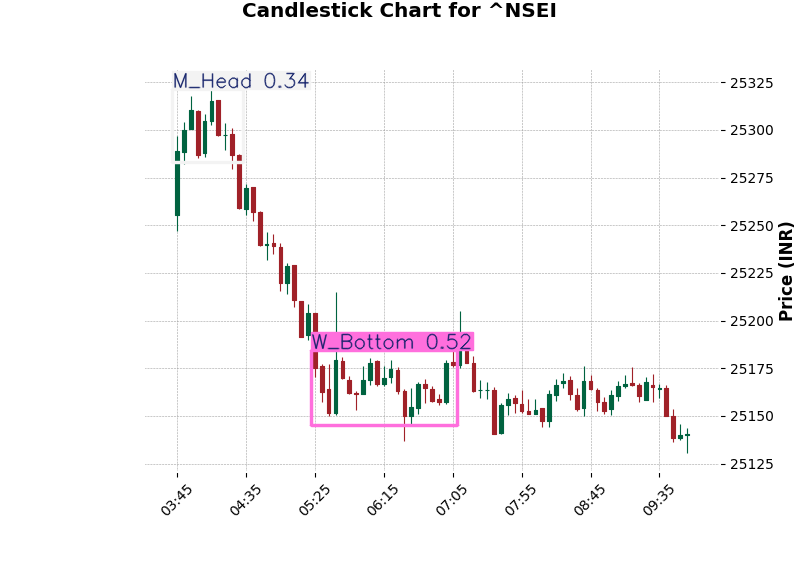

Annotated image saved to: annotated_images/^NSEI_annotated.png


[*********************100%***********************]  1 of 1 completed

0: 480x640 1 W_Bottom, 1520.9ms
Speed: 2.7ms preprocess, 1520.9ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 640)
detected pattern: ['W_Bottom']
Detected pattern: W_Bottom


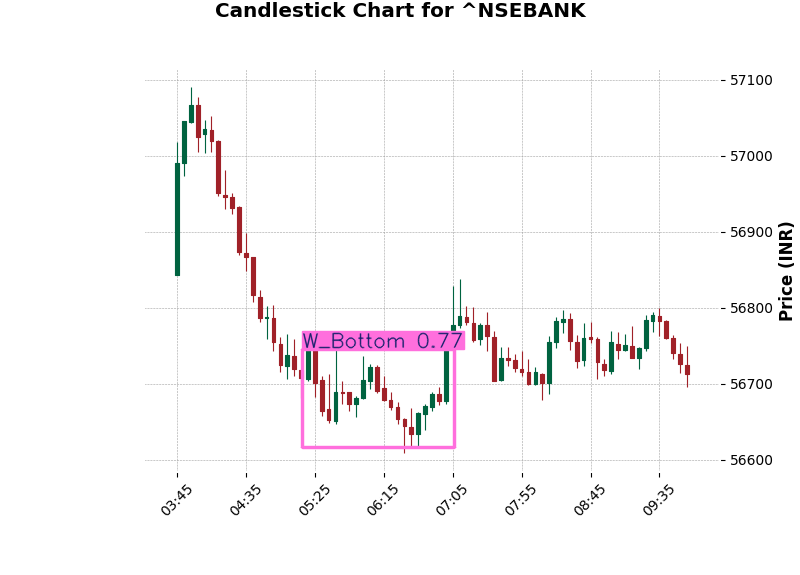

Annotated image saved to: annotated_images/^NSEBANK_annotated.png
PDF created: annotated_images_2025-07-11.pdf


In [18]:
run_data_indices()

In [19]:
# run_data()

In [20]:
# This loop will continuously run the run_data_indices() function every 5 minutes (300 seconds).
# Uncomment to enable periodic pattern detection and reporting for the indices.
# while(1):
#   run_data_indices()
#   time.sleep(300)

In [21]:
# prompt: add code to read the excel file and print the contents

import pandas as pd
# Assuming the excel file is named 'detected_patterns.xlsx' and is in the content directory
excel_file_path = '/content/detected_patterns.xlsx'

try:
    # Read the Excel file into a pandas DataFrame
    df = pd.read_excel(excel_file_path)

    # Print the contents of the DataFrame
    print(df)

except FileNotFoundError:
    print(f"Error: Excel file not found at {excel_file_path}")
except Exception as e:
    print(f"An error occurred while reading the Excel file: {e}")


             Timestamp    ticker Detected Pattern
0  2025-07-11_17-55-30     ^NSEI           M_Head
1  2025-07-11_17-55-32  ^NSEBANK         W_Bottom
